In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df_samples = pd.read_csv('data.csv')

df_samples.head()

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [3]:
df_filtered = df_samples[['filename', 'tempo', 'beats', 'label']]

df_filtered = df_filtered.rename(columns={
    'filename': 'Name',
    'tempo': 'Tempo',
    'beats': 'Beats',
    'label': 'Genre',
})
df_filtered.head()

,Name,Tempo,Beats,Genre
0,blues.00081.au,103.359375,50,blues
1,blues.00022.au,95.703125,44,blues
2,blues.00031.au,151.999081,75,blues
3,blues.00012.au,184.570312,91,blues
4,blues.00056.au,161.499023,74,blues


# Average Tempo of each Label/Genre

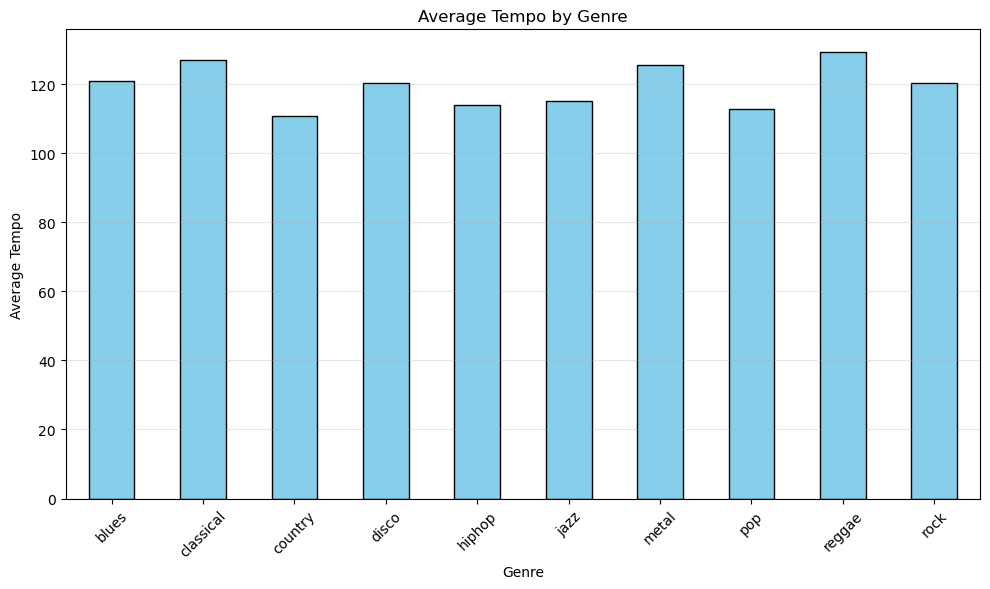

In [4]:
import matplotlib.pyplot as plt

average_tempo = df_filtered.groupby('Genre')['Tempo'].mean()


plt.figure(figsize=(10, 6))
average_tempo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Tempo by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Tempo')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Average Beats of each Label/Genre

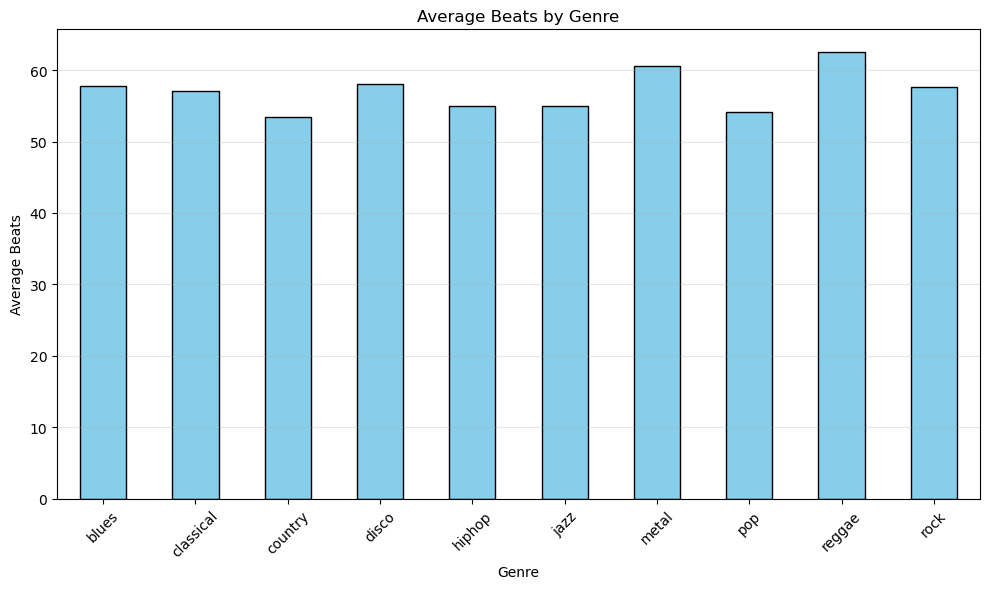

In [5]:
average_tempo = df_filtered.groupby('Genre')['Beats'].mean()


plt.figure(figsize=(10, 6))
average_tempo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Beats by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Beats')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

We would expect the average beats to correlate to the average tempo of each genre, we test that here

In [6]:
from scipy.stats import pearsonr, spearmanr

average_values = df_filtered.groupby('Genre')[['Tempo', 'Beats']].mean()

pearson_corr, pearson_p = pearsonr(average_values['Tempo'], average_values['Beats'])

spearman_corr, spearman_p = spearmanr(average_values['Tempo'], average_values['Beats'])

print(f"Pearson Correlation: {pearson_corr:.2f}, P-value: {pearson_p:.4f}")
print(f"Spearman Correlation: {spearman_corr:.2f}, P-value: {spearman_p:.4f}")

Pearson Correlation: 0.91, P-value: 0.0003
Spearman Correlation: 0.85, P-value: 0.0016


The small p value indicates a significant correlation between tempo and beats

# Building a classifier

In [7]:
# select features and labels
features = df_samples.drop(columns = ['filename', 'label'])
labels = df_samples['label']

In [8]:
# feature engineering: scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [9]:
# dimensionality reduction with PCA
pca = PCA(n_components = 2)
pca_features = pca.fit_transform(scaled_features)

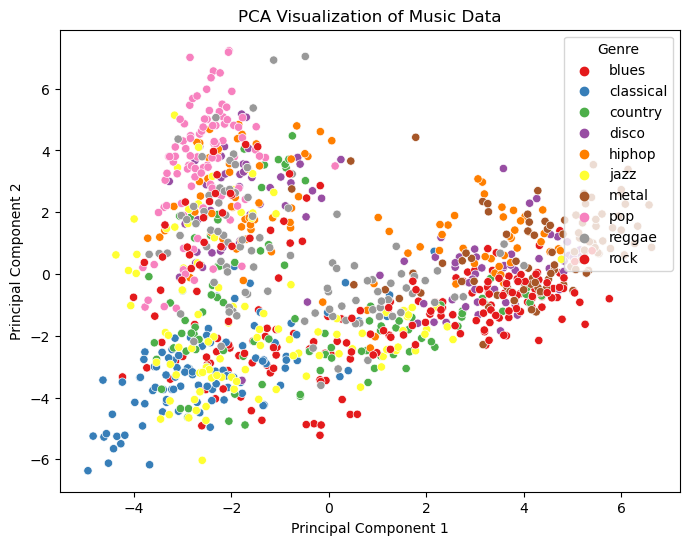

In [10]:
# plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pca_features[:, 0], y = pca_features[:, 1], hue = labels, palette = "Set1")
plt.title("PCA Visualization of Music Data")
plt.xlabel("Principal Component 1") # Principal Component 1: Represents the direction of maximum variance in the data, capturing the most important patterns.
plt.ylabel("Principal Component 2") # Principal Component 2: Orthogonal to PC1, it captures the second most significant variance, highlighting additional data structure.
plt.legend(title = "Genre", loc = 'upper right')
plt.show()

# Lets try using GMM

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, accuracy_score

In [12]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, encoded_labels, test_size=0.3, random_state=42)

# Train a GMM for each genre
unique_labels = np.unique(y_train)
gmms = {label: GaussianMixture(n_components=2, random_state=42) for label in unique_labels}

# Fit GMMs
for label in unique_labels:
    gmms[label].fit(X_train[y_train == label])

# Predict using GMMs
def predict_gmm(x):
    likelihoods = [gmms[label].score_samples(x.reshape(1, -1)) for label in unique_labels]
    return unique_labels[np.argmax(likelihoods)]

# Classify test data
y_pred = np.array([predict_gmm(sample) for sample in X_test])

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Output the results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

c:\Users\William\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\William\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\William\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\William\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

Accuracy: 0.43

Classification Report:
               precision    recall  f1-score   support

       blues       0.67      0.23      0.34        35
   classical       0.47      0.90      0.62        20
     country       0.28      0.49      0.35        37
       disco       0.39      0.32      0.35        34
      hiphop       0.21      0.33      0.25        24
        jazz       0.83      0.30      0.44        33
       metal       0.70      0.53      0.60        30
         pop       0.63      0.83      0.72        23
      reggae       0.32      0.34      0.33        29
        rock       0.50      0.31      0.39        35

    accuracy                           0.43       300
   macro avg       0.50      0.46      0.44       300
weighted avg       0.50      0.43      0.43       300



As we can see the accuracy is pretty low, I am going to test the prediction 10 test datas to get an idea of the clasifying

In [39]:
import random

for i in range(100):
    # Select a random sample from the test data
    random_index = random.randint(0, X_test.shape[0] - 1)
    random_sample = X_test[random_index]
    true_label = y_test[random_index]

    # Display the sample's true label
    print(f"Prediction {i+1}:")
    print(f"True Label: {label_encoder.inverse_transform([true_label])[0]}")

    # Compute likelihoods for each label
    likelihoods = np.array([gmms[label].score_samples(random_sample.reshape(1, -1)) for label in unique_labels])

    # Predicted label
    predicted_label = unique_labels[np.argmax(likelihoods)]
    predicted_genre = label_encoder.inverse_transform([predicted_label])[0]

    # Display predicted genre
    print(f"Predicted Genre: {predicted_genre}\n")


Prediction 1:
True Label: metal
Predicted Genre: metal

Prediction 2:
True Label: rock
Predicted Genre: hiphop

Prediction 3:
True Label: pop
Predicted Genre: pop

Prediction 4:
True Label: classical
Predicted Genre: classical

Prediction 5:
True Label: metal
Predicted Genre: metal

Prediction 6:
True Label: disco
Predicted Genre: hiphop

Prediction 7:
True Label: blues
Predicted Genre: rock

Prediction 8:
True Label: hiphop
Predicted Genre: classical

Prediction 9:
True Label: jazz
Predicted Genre: reggae

Prediction 10:
True Label: reggae
Predicted Genre: reggae

Prediction 11:
True Label: jazz
Predicted Genre: jazz

Prediction 12:
True Label: blues
Predicted Genre: blues

Prediction 13:
True Label: disco
Predicted Genre: pop

Prediction 14:
True Label: jazz
Predicted Genre: reggae

Prediction 15:
True Label: country
Predicted Genre: hiphop

Prediction 16:
True Label: rock
Predicted Genre: rock

Prediction 17:
True Label: classical
Predicted Genre: classical

Prediction 18:
True Labe

These results correlate with the precisions we see on the correlation table. The classifier seems to struggle classifying hiphop, pop and disco and mistaking them for each other often as well as blues, classical, jazz. Which makes sense because these respective types of music will have similar musical elements.